# DEM-GNN Rollout Evaluation

## Import dependencies

In [1]:
import torch
import torch.nn.functional as F

from torch_geometric.data import Batch, Data, DataLoader, InMemoryDataset
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm, trange
from IPython.display import clear_output
from typing import Literal

torch.cuda.is_available()

True

In [2]:
sim = np.zeros(shape=(10))
for t in np.arange(len(sim)-1):
    step_max = 4
    push_forward_steps = np.random.randint(0,step_max+1)
    push_forward_steps = min(push_forward_steps,len(sim)-t-2)
    print(push_forward_steps)

3
2
2
1
1
3
2
1
0


In [3]:
for k in range(4):
    print(k)

0
1
2
3


## Loading and training on datasets

In [4]:
from ML_functions import DEM_Dataset, Trainer, GetModel
dataset_name="2Sphere"
model_ident = "NewModel_1"
data_split=[0.85, 0.95]
pre_transform = T.Compose([T.Cartesian(False),
                           T.Distance(norm=False,cat=True)])
transform       = None
force_reload    = False
train           = False

[dataset_train, dataset_val, dataset_test]      = [DEM_Dataset(dataset_name,
                                                               dataset_type,
                                                               mode             = 'delta',
                                                               force_reload     = force_reload,
                                                               pre_transform    = pre_transform,
                                                               super_tol        = 6,
                                                               tol              = 0,
                                                               noise_factor     = 0) 
                                                               for dataset_type in ["train","validate","test"]]

if train == True:
    model = GetModel(dataset_name,model_ident,edge_dim=4)
    trainer = Trainer(model, dataset_train,dataset_val,
                      batch_size=32,
                      lr=0.0000001,
                      epochs=2000,
                      model_name=f"{dataset_name}{model_ident}")
    #trainer.train_loop()

c:\Users\20182319\AppData\Local\anaconda3\envs\DEM-GNN2\Lib\site-packages\torch_geometric\io\fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([_reconstruct])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


## Defining Rollout functions

In [5]:
def AverageDX(data):
    norm = torch.norm(data.y,dim=1)
    return torch.mean(norm)

dataset_test.y.abs().mean().item()

0.7958528060863196

In [6]:
print(f"x_max:      {dataset_test.x.max(dim=0)[0]}")
print(f"y_mean:     {dataset_test.y.mean(dim=0)}")
print(f"y_std:      {dataset_test.y.std(dim=0)}")
print(f"edge_mean:  {dataset_test.edge_attr.mean(dim=0)}")
print(f"edge_std:   {dataset_test.edge_attr.std(dim=0)}")

x_max:      tensor([0.9990, 0.9940, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000],
       dtype=torch.float64)
y_mean:     tensor([-1.2406e-07, -5.9444e-08,  1.3780e-16], dtype=torch.float64)
y_std:      tensor([1.0265, 1.0161, 1.0251], dtype=torch.float64)
edge_mean:  tensor([ 2.2363e-03,  7.1348e-04, -3.0543e-13,  7.5886e-02],
       dtype=torch.float64)
edge_std:   tensor([1.0251, 1.0249, 1.0251, 1.0040], dtype=torch.float64)


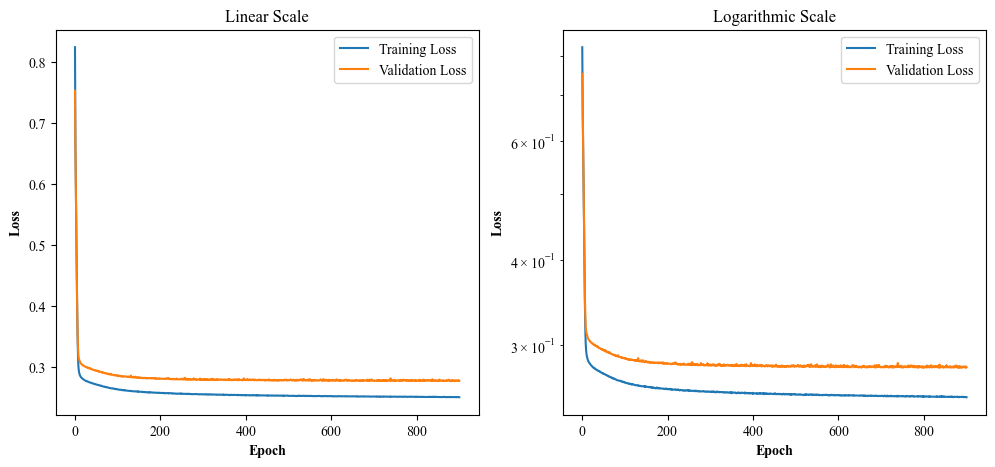

In [7]:
from Plotting import PlotTrainingLoss
try: fig, axs = PlotTrainingLoss(dataset_name,model_ident)
except: print("Failed plot")

## Generating Rollouts

In [8]:
from Plotting import PlotXYZ
from ML_functions import LearnedSimulator, NormalizeData, GetModel, Rescale, NormalizePos, MaskTestData
dataset_name="2Sphere"
model_ident = "NewModel_1"
model = GetModel(dataset_name,model_ident)
AggregatedArgs = MaskTestData(dataset_name,"test")

Loaded model


Calculating BC


100%|██████████| 100/100 [00:00<00:00, 25075.05it/s]


100%|██████████| 100/100 [00:00<00:00, 755.00it/s]


Calculating Learned Rollout


100it [00:01, 73.33it/s]                        


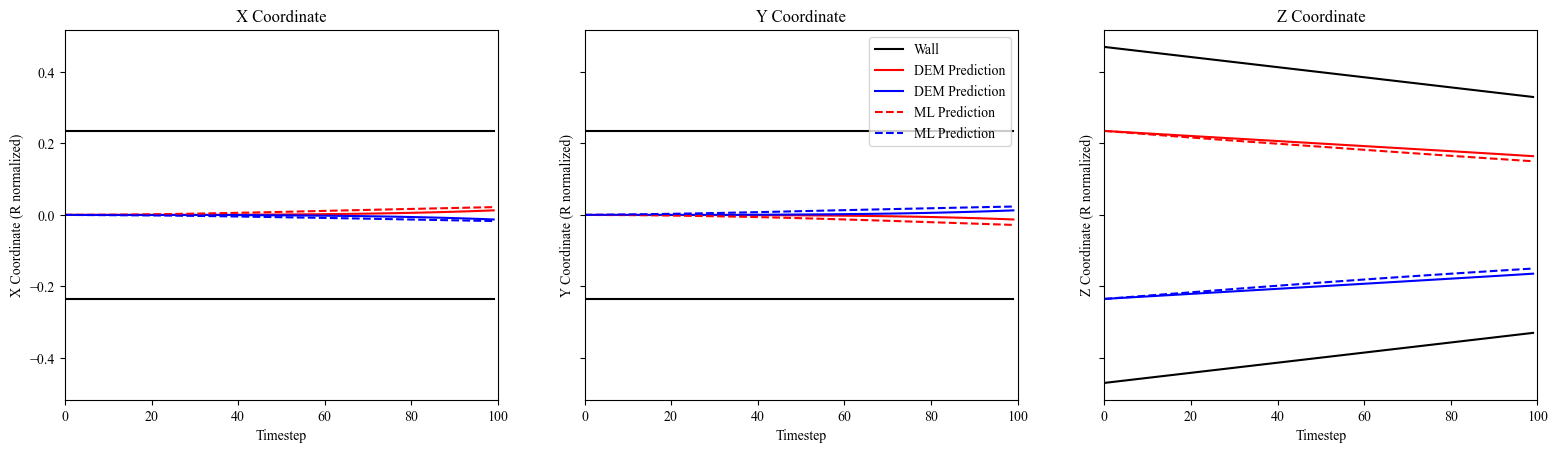

In [9]:
for sample_idx in [5]:
    Simulation = LearnedSimulator(sample_idx,model,*AggregatedArgs,
                                  scale_function = Rescale(dataset_name),
                                  super_tol = 6,
                                  tol       = 0,
                                  transform = T.Compose([T.Cartesian(False),T.Distance(norm=False,cat=True),NormalizeData(dataset_name)]),
                                  timesteps = 100)
    Simulation.Rollout()
    if dataset_name == "2Sphere": 
        PlotXYZ(Simulation,t_max=100, normalize=False)

## Evaluating Rollouts

In [ ]:
from Plotting import PlotGraphComparison
save = False
show = True
for t in [99]:  
    fig = PlotGraphComparison(t,Simulation,sample_idx,Simulation.tol,plot_lines=True)
    if save == True: plt.savefig(f"{os.getcwd()}\\Figures\\Plots\\Graph_Sample{sample_idx}_Time{t}_Tol{str(Simulation.tol)[2:]}.png",bbox_inches='tight')     
    if show == True: plt.show()

In [ ]:
from Plotting import PlotFres
from Evaluation import AggregateForces
Fcontact_GT,Fres_GT, Fnorm_GT, Fsum_GT = AggregateForces(Simulation.GroundTruth)
Fcontact_ML,Fres_ML, Fnorm_ML, Fsum_ML = AggregateForces(Simulation.ML_rollout)
fig = PlotFres(Fsum_GT,Fsum_ML)

In [ ]:
from Plotting import PlotStressComparison
fig, axs = PlotStressComparison(Simulation,Fcontact_GT,Fcontact_ML,Plot_ML=True)

In [ ]:
from Plotting import PlotForceDistributionComparison
quantiles = [1,5,10,25,50]
fig, ax = PlotForceDistributionComparison(Fnorm_GT,Fnorm_ML,quantiles,True)

In [ ]:
import pyvista as pv
from Plotting import MakeGIF, PlotMeshNormals


#datalist = Rollout.ML_rollout
#gifname = f"ML_2_{sample_idx}_Tol{str(tol)[2:]}"
gifname = f"{dataset_name}_{model_ident}_deform"
datalist = Simulation.GroundTruth
#datalist = Rollout.ML_rollout
MakeGIF(datalist,gifname,fps=8,color='lightblue',deformation=True)

#data = Rollout.ML_rollout[10]
#data = Rollout.GroundTruth[0]
#PlotMeshNormals(data)


## Testing New Code

In [ ]:
AggregatedArgs = MaskTestData(dataset_name)
data,top,bc = AggregatedArgs
par_data = data[0][0]
print(par_data)
R_avg = par_data[0,3]
noise_factor = 0.01
standard_deviation = noise_factor*R_avg
noise = np.array(standard_deviation*torch.randn((par_data.shape[0],3)))
par_data[:,:3]+=noise
print(par_data)

In [ ]:
from Encoding import ConstructTopology
AggregatedArgs = MaskTestData(dataset_name)
data,top,bc = AggregatedArgs
data = data[0]
top = top[0]
bc = bc[0]
t=0
BC_t = bc.copy()
BC_t[:,:3] = bc[:,:3]+(t+1)*bc[:,-3:]

print(data.shape)
R_avg = data[0,:,3].mean()
par_data = data[0]
super_topology = ConstructTopology(par_data,BC_t,1)-1
print(par_data)

In [ ]:
t=40
BC_t = bc.copy()
BC_t[:,:3] = bc[:,:3]+(t+1)*bc[:,-3:]
bc=BC_t
par_data = data[t]
top0 = ConstructTopology(par_data,bc,0)-1

from Encoding import TopologyFromPlausibleTopology
topology_sub = TopologyFromPlausibleTopology(super_topology,par_data,BC_t,0)

topology_sub == top0,topology_sub

In [ ]:
from Evaluation import GetGamma
gamma = GetGamma(data)
gamma

## Old Code

In [ ]:
def FilterStart(dataset):
    idx = np.nonzero([data.time == 0 for data in dataset])
    return torch.utils.data.Subset(dataset_test,idx)[0]

#dataset_test_start = FilterStart(dataset_test)

In [ ]:
from Encoding import ToPytorchData, GetLength

def GetLimits(data):
    max = [torch.max(data.x[:,i]) for i in [0, 1, 2]]
    min = [torch.min(data.x[:,i]) for i in [0, 1, 2]]
    max = torch.stack(max)
    min = torch.stack(min)
    limits = torch.stack([min,max],dim=1)
    return limits


In [ ]:
from Encoding import load
def SplitData(dataset_name,data_split):
    loaded_data = load(dataset_name)
    splits=np.array(data_split)*loaded_data[0].shape[0]
    test_data = [np.split(data,splits.astype(int))[2] for data in loaded_data]
    return test_data

In [ ]:
from Evaluation import GetContactForce
from Encoding import ConvertToDirected
data = Rollout.GroundTruth[0].clone()
force = GetContactForce(data)
GT = np.loadtxt('PairContact001.txt')

data =ConvertToDirected(data)
force2 = GetContactForce(data)

print(torch.norm(force,dim=1).size())
print(torch.norm(force2,dim=1))

torch.all(np.round(GT[:,2],2)==torch.round(torch.norm(force2,dim=1),decimals=2))

In [ ]:
from Plotting import GetInternalStressRollout
stress = GetInternalStressRollout(Rollout)
torch.set_printoptions(4)
print("Stress at time 0")
print(torch.round(stress[0],decimals=8)),
print("\nStress at time 99")
print(torch.round(stress[-1],decimals=1))

In [ ]:
from Plotting import PlotContactVectorAndForce, GetAllContactpoints,AxesLimits
data = Rollout.GroundTruth[0]
BC = Rollout.BC_rollout[3]
fig,axs = PlotContactVectorAndForce(data,BC)
for ax in axs: AxesLimits(ax,BC)

In [ ]:
data = Rollout.ML_rollout[0]
#data = Rollout.GroundTruth[0]